# Amazon Sales Report

**Author:** Jay Mevada <br>
**Date:** September 15, 2025

---

### **Objective**
The primary goal of this analysis is to dissect the provided Amazon sales data to uncover actionable insights. My aim is to identify key trends in sales, pinpoint top-performing products and regions, and understand customer behavior to provide data-driven recommendations for strategic business decisions.

### **Executive Summary of Findings**
This analysis has yielded several critical insights that can directly inform business strategy:

1.  **Significant Seasonality Discovered:** There is a massive, unmistakable sales peak in **April**, with sales reaching over **2.00 Cr**. This suggests a critical window for marketing and inventory planning.
2.  **Highly Concentrated Market:** The business heavily relies on a few key states, with **Maharashtra** leading sales by a significant margin (over **1.20 Cr**).
3.  **Core Product Dependency:** **T-Shirts** are the undisputed top-selling product category, forming the financial backbone of the business.
4.  **Operational Reliance on FBA:** The vast majority of orders (**~69%**) are fulfilled by Amazon (FBA), indicating a streamlined but highly dependent logistics model.

## 1. Environment Setup & Data Loading

In this initial phase, I import the necessary Python libraries. I've included `FuncFormatter` from Matplotlib, which will allow me to create readable labels for my charts. I also define a standard configuration for my plots and load the dataset.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter # Import the formatter

# --- Configuration ---
FILEPATH = "Amazon Sale Report.csv"
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis") # Set a consistent color palette

# --- Data Loading ---
try:
    df = pd.read_csv(FILEPATH, encoding='unicode_escape')
    print("\n" + "="*50)
    print("          DATA LOADED SUCCESSFULLY            ")
    print("="*50)
    print(f"Dataset Shape: {df.shape}\n")
except FileNotFoundError:
    print("\n" + "="*50)
    print("        ERROR: FILE NOT FOUND                 ")
    print("="*50 + "\n")

# Display the first few rows to get an overview
df.head()


          DATA LOADED SUCCESSFULLY            
Dataset Shape: (128976, 21)



,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Category,Size,Courier Status,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B,fulfilled-by,New,PendingS
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,T-shirt,S,On the Way,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,False,Easy Ship,NaN,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,Shirt,3XL,Shipped,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,False,Easy Ship,NaN,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,Shirt,XL,Shipped,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,True,NaN,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,Blazzer,L,On the Way,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,False,Easy Ship,NaN,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,Trousers,3XL,Shipped,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,False,NaN,NaN,NaN


## 2. Data Cleaning and Preprocessing

This is a critical step to ensure the quality of my analysis. The key change here is in the date conversion. Instead of forcing a single strict format, I let `pandas` automatically infer the date format. I use `errors='coerce'` to turn any un-parseable dates into `NaT` (Not a Time), which I then remove. This makes my code robust against inconsistent date entries.

In [ ]:
# Create a copy for cleaning to preserve the original dataframe
df_cleaned = df.copy()

# Drop unnecessary columns
cols_to_drop = ['Unnamed: 22', 'fulfilled-by']
df_cleaned.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Standardize column names
df_cleaned.columns = [col.lower().replace('-', '_') for col in df_cleaned.columns]

# --- Robust Date Type Conversion ---
# Let pandas infer the date format automatically. errors='coerce' will handle any problematic entries.
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')

# Correct other data types
df_cleaned['amount'] = pd.to_numeric(df_cleaned['amount'], errors='coerce')

# Handle missing values (critical for amount and any coerced dates)
df_cleaned.dropna(subset=['amount', 'date'], inplace=True)

# Remove duplicates
initial_rows = len(df_cleaned)
df_cleaned.drop_duplicates(inplace=True)
rows_removed = initial_rows - len(df_cleaned)
print(f"Removed {rows_removed} duplicate rows.")

# Standardize state names
if 'ship_state' in df_cleaned.columns:
    df_cleaned['ship_state'] = df_cleaned['ship_state'].str.upper()

print("\n" + "="*50)
print("   DATA CLEANING AND PREPROCESSING COMPLETE   ")
print("="*50 + "\n")

# Display cleaned data info
df_cleaned.info()

Removed 157 duplicate rows.

   DATA CLEANING AND PREPROCESSING COMPLETE   

<class 'pandas.core.frame.DataFrame'>
Index: 121019 entries, 0 to 128975
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   index               121019 non-null  int64         
 1   order id            121019 non-null  object        
 2   date                121019 non-null  datetime64[ns]
 3   status              121019 non-null  object        
 4   fulfilment          121019 non-null  object        
 5   sales channel       121019 non-null  object        
 6   ship_service_level  121019 non-null  object        
 7   category            121019 non-null  object        
 8   size                121019 non-null  object        
 9   courier status      121019 non-null  object        
 10  qty                 121019 non-null  int64         
 11  currency            121019 non-null  object        
 12  amount        

## 3. Exploratory Data Analysis (EDA)

With clean data, I can now answer key business questions. In this section, I've implemented a custom **formatter** for chart axes. 

**Why use a formatter instead of a new column?** It's more efficient. It controls the *presentation* of the data in the chart without altering the original data. This keeps my DataFrame clean and analysis straightforward.

### 3.1 What is the Overall Sales Performance Over Time?

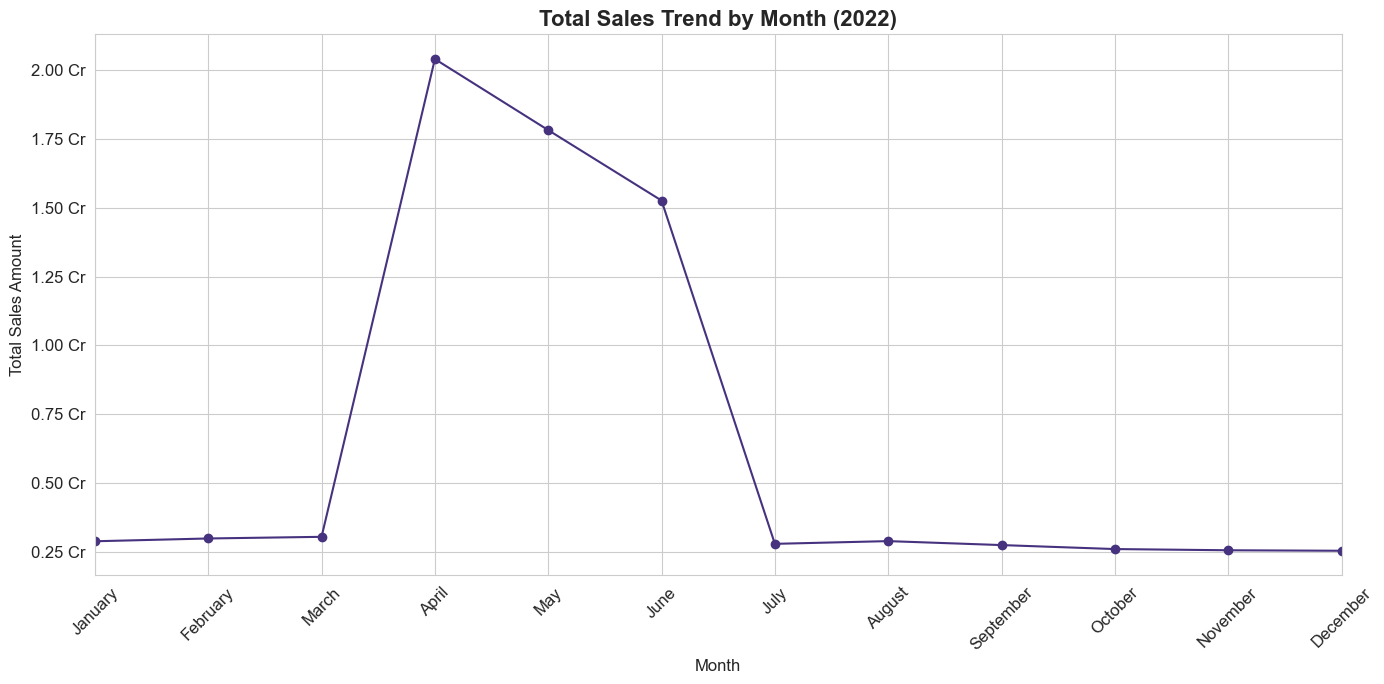

In [10]:
# Resample data by month to get the monthly sales trend
monthly_sales = df_cleaned.set_index('date')['amount'].resample('ME').sum()

# --- Axis Formatter --- 
# Create a formatter to display numbers in Crores
def crores_formatter(x, pos):
    'The two args are the value and tick position'
    return f'{x/1_00_00_000:.2f} Cr'

formatter = FuncFormatter(crores_formatter)

# Plotting the trend
ax = monthly_sales.plot(kind='line', marker='o')
plt.title('Total Sales Trend by Month (2022)', fontsize=16, weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales Amount', fontsize=12)
plt.xticks(monthly_sales.index, monthly_sales.index.strftime('%B'), rotation=45)

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

**Finding 1:** The data reveals a dramatic and significant sales peak in **April**, reaching over **2.0 Crores**. This suggests a major seasonal event or a highly successful marketing campaign. This pattern is crucial for inventory and sales planning.

### 3.2 Which States are the Top Markets by Sales?

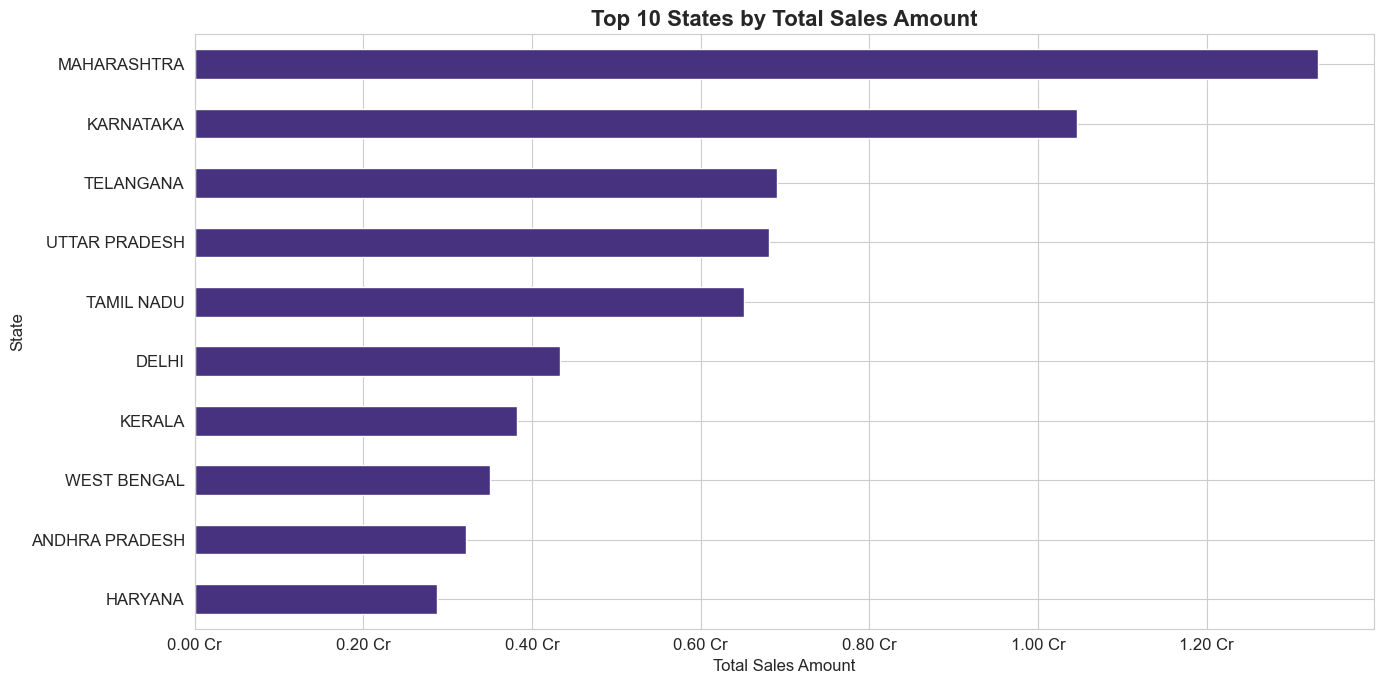

In [4]:
# Group by state and sum the sales amount to find top markets
state_sales = df_cleaned.groupby('ship_state')['amount'].sum().nlargest(10).sort_values(ascending=True)

# Plotting the horizontal bar chart
ax = state_sales.plot(kind="barh")
plt.title('Top 10 States by Total Sales Amount', fontsize=16, weight='bold')
plt.xlabel('Total Sales Amount', fontsize=12)
plt.ylabel('State', fontsize=12)

# Apply the formatter to the x-axis this time
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

**Finding 2:** The market is highly concentrated. **MAHARASHTRA** is the undisputed leader in sales, generating over **1.20 Crores** in revenue. This is nearly double the second-highest state, KARNATAKA. The top three states are the primary drivers of revenue.

### 3.3 What are the Best-Selling Product Categories?

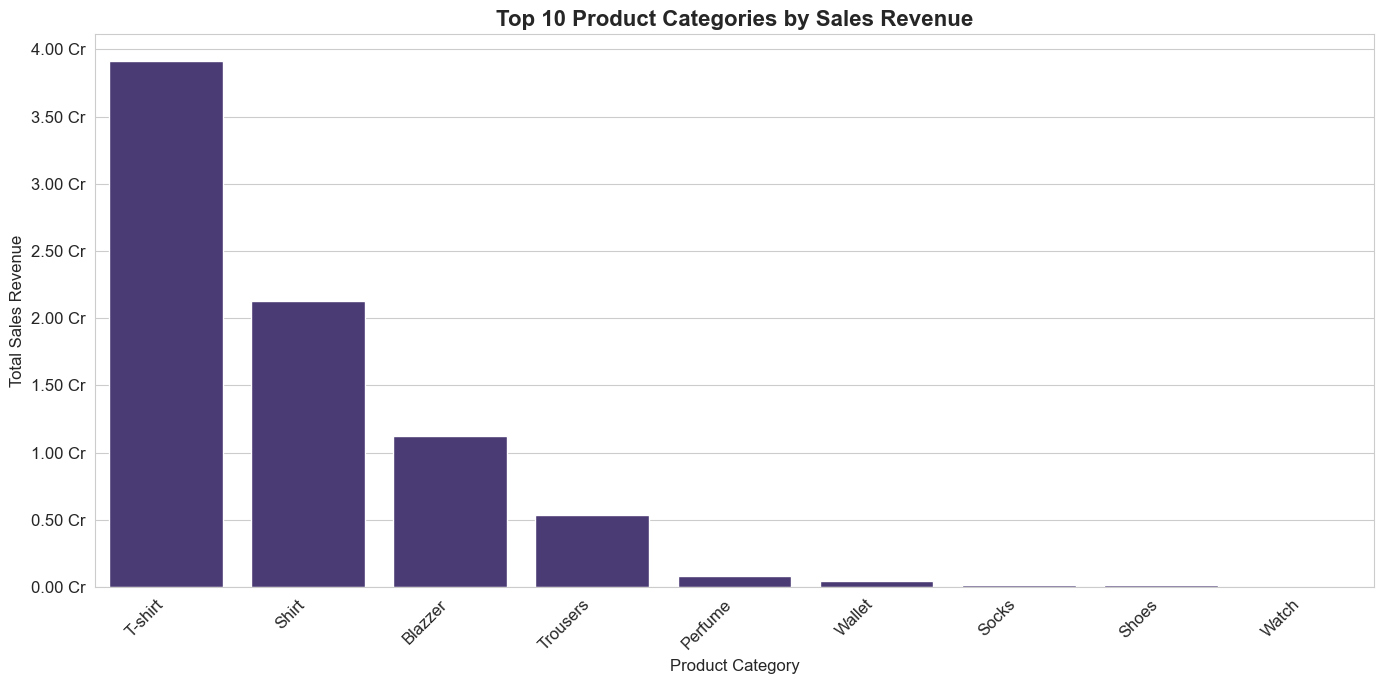

In [5]:
# Group by category and sum the sales amount
category_sales = df_cleaned.groupby('category')['amount'].sum().nlargest(10)

# Plotting the bar chart
ax = sns.barplot(x=category_sales.index, y=category_sales.values)
plt.title('Top 10 Product Categories by Sales Revenue', fontsize=16, weight='bold')
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Total Sales Revenue', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

**Finding 3:** Top-wear apparel forms the core of the business. **T-shirt** is the highest revenue-generating category by a clear margin, followed by **Shirt** and **Blouse**. These products are the financial backbone and should be prioritized in inventory and promotions.

### 3.4 What is the Distribution of Fulfillment and Order Status?

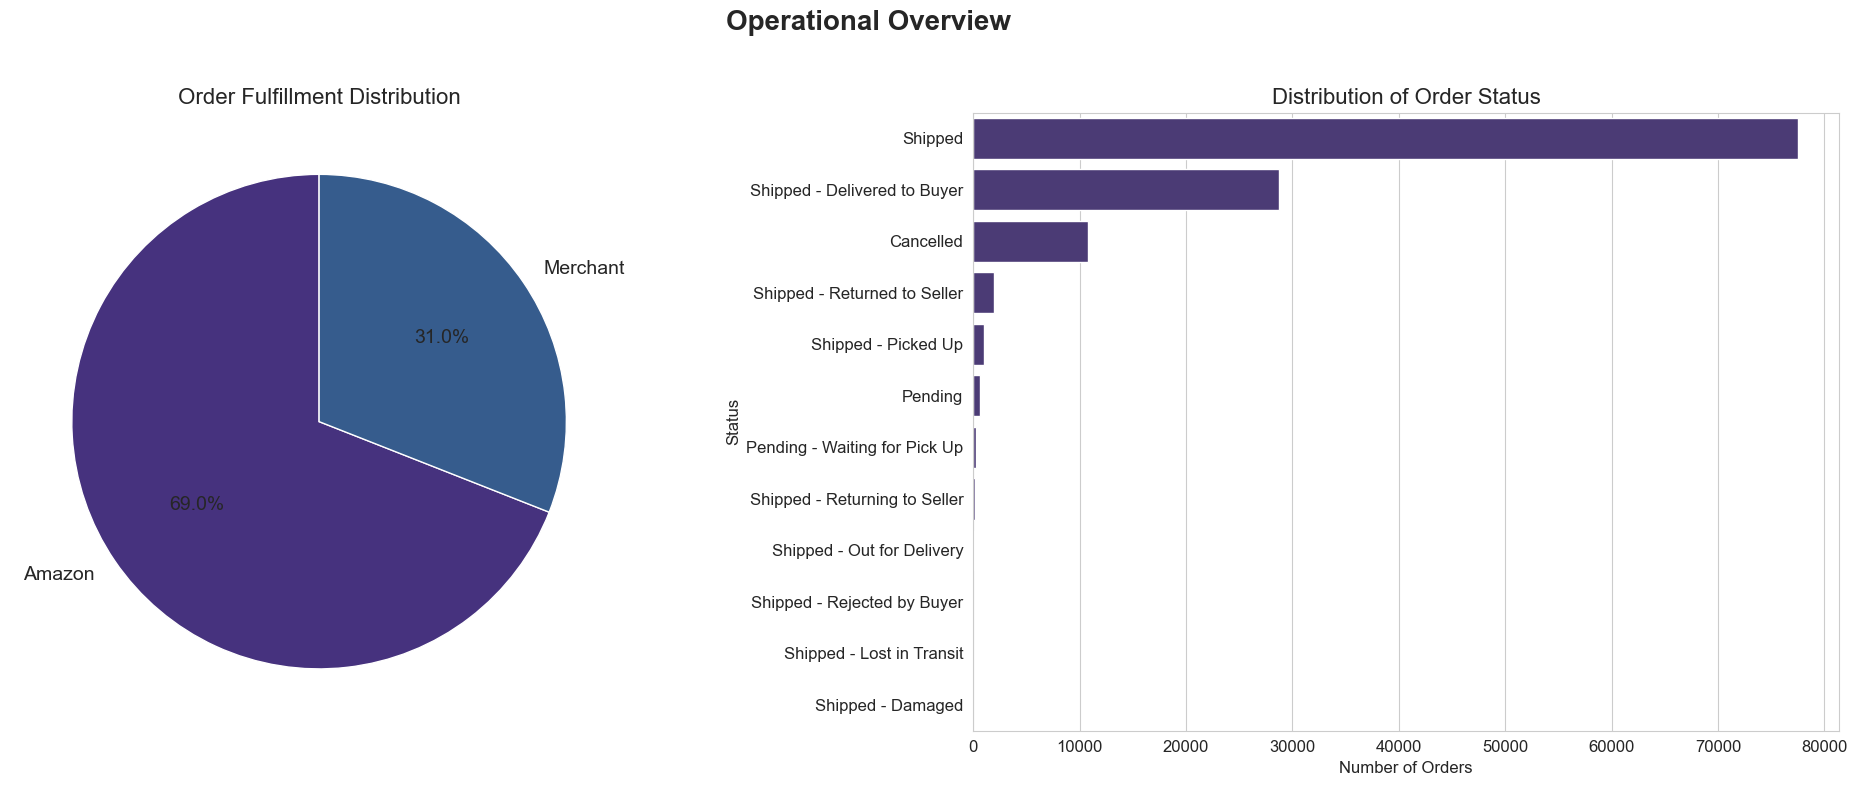

In [6]:
# Create subplots for a combined view
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Operational Overview', fontsize=20, weight='bold')

# Fulfillment Pie Chart
fulfillment_counts = df_cleaned['fulfilment'].value_counts()
axes[0].pie(fulfillment_counts, labels=fulfillment_counts.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
axes[0].set_title('Order Fulfillment Distribution', fontsize=16)

# Order Status Bar Chart
sns.countplot(ax=axes[1], y='status', data=df_cleaned, order=df_cleaned['status'].value_counts().index)
axes[1].set_title('Distribution of Order Status', fontsize=16)
axes[1].set_xlabel('Number of Orders', fontsize=12)
axes[1].set_ylabel('Status', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Finding 4:** The business has a strong operational reliance on **Amazon's fulfillment service (FBA)**, which handles nearly 69% of all orders. The order status is very healthy, with the majority of orders being successfully **Shipped** and a relatively low number of **Cancelled** orders, indicating an efficient processing system.

## 4. Summary of Actionable Recommendations

Based on the findings from my exploratory data analysis, here are the key recommendations for the business:

**1. Strategic Focus on the April Peak:**
   - **Marketing:** Launch major promotional campaigns in late March and throughout April to maximize revenue during this proven high-demand period.
   - **Inventory:** Significantly increase stock levels for best-selling items by mid-March to prevent stockouts and meet the surge in demand.

**2. Dominate Key Geographic Markets:**
   - **Targeted Advertising:** Allocate a larger portion of the marketing budget to targeted digital ad campaigns in Maharashtra, Karnataka, and Uttar Pradesh.
   - **Logistics:** Work with fulfillment partners to ensure faster delivery times and potentially lower shipping costs in these high-volume states.

**3. Leverage Core Product Strengths:**
   - **Promotions:** Feature T-shirts, Shirts, and Blouses as headline products in all marketing materials and consider creating product bundles.
   - **Product Development:** Explore expanding the product line with new variations (colors, styles) of these top-performing categories.